# Predicting Particulate Matter (PM2.5) Concentrations in the Air of China

# Implementation

In [6]:
# Import libraries necessary for this project
import csv
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Dara preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
# Import train_test_split
from sklearn.model_selection import ShuffleSplit
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd

In [12]:
# Load Guangzhou dataset
Guangzhou = pd.read_csv('dataset_Guangzhou_clean.csv')
Guangzhou = Guangzhou.drop('Unnamed: 0', axis = 1)

# Load Beijing dataset
Beijing = pd.read_csv('dataset_Beijing_clean.csv')
Beijing = Beijing.drop('Unnamed: 0', axis = 1)

# Load Chengdu dataset
Chengdu = pd.read_csv('dataset_Chengdu_clean.csv')
Chengdu = Chengdu.drop('Unnamed: 0', axis = 1)

# Load Shanghai dataset
Shanghai = pd.read_csv('dataset_Shanghai_clean.csv')
Shanghai = Shanghai.drop('Unnamed: 0', axis = 1)

# Load Shenyang dataset
Shenyang = pd.read_csv('dataset_Shenyang_clean.csv')
Shenyang = Shenyang.drop('Unnamed: 0', axis = 1)

# All five cities in one dataset 
dataset = Beijing.append(Chengdu, ignore_index=True, sort=True)
dataset = dataset.append(Shanghai, ignore_index=True, sort=True)
dataset = dataset.append(Shenyang, ignore_index=True, sort=True)
dataset = dataset.append(Guangzhou, ignore_index=True, sort=True)

dataset = dataset.drop(['day_cos', 'day_sin', 'precipitation'],axis = 1 )
dataset = dataset.rename(columns={"DEWP": "Dew Point", "HUMI": "Humidity", "PM_US Post" : "PM 2.5", 
                       "PRES": "Pressure", "TEMP": "Temperature", "cbwd_NE": "Wind dir_NE", "cbwd_NW": "Wind dir_NW", 
                       "cbwd_SE": "Wind dir_SE", "cbwd_SW":"Wind dir_SW", "cbwd_cv": "Wind dir_cv", 
                       "new_wind": "Wind speed", "season_1" : "Spring", "season_2" : "Autumn",
                        "season_3" : "Summer", "season_4" : "Winter", "year":"Year"
                       })


# coastal citie: 
coastal_citie = Guangzhou.append(Shanghai, ignore_index=True, sort=True)

Beijing_Shenyang = Beijing.append(Shenyang, ignore_index=True, sort=True)

# Total number of records
n_records = len(dataset["PM 2.5"])
print("Number of records for all Chines cities: ", n_records)
print("*********************")
display(dataset.info())
display(dataset.describe())


print('The statistical summary of air quality data in China')
np.round(dataset.describe(), 2).T[['count','mean', 'std', 'min','25%','50%','75%' ,'max']]

Number of records for all Chines cities:  117200
*********************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117200 entries, 0 to 117199
Data columns (total 22 columns):
Dew Point      117200 non-null float64
Humidity       117200 non-null float64
PM 2.5         117200 non-null float64
Pressure       117200 non-null float64
Temperature    117200 non-null float64
Weekdays       117200 non-null int64
Weekends       117200 non-null int64
Wind dir_NE    117200 non-null int64
Wind dir_NW    117200 non-null int64
Wind dir_SE    117200 non-null int64
Wind dir_SW    117200 non-null int64
Wind dir_cv    117200 non-null int64
hour_cos       117200 non-null float64
hour_sin       117200 non-null float64
month_cos      117200 non-null float64
month_sin      117200 non-null float64
Wind speed     117200 non-null float64
Spring         117200 non-null int64
Autumn         117200 non-null int64
Summer         117200 non-null int64
Winter         117200 non-null int64
year           117200

None

,Dew Point,Humidity,PM 2.5,Pressure,Temperature,Weekdays,Weekends,Wind dir_NE,Wind dir_NW,Wind dir_SE,...,hour_cos,hour_sin,month_cos,month_sin,Wind speed,Spring,Autumn,Summer,Winter,year
count,117200.000000,117200.000000,117200.000000,117200.000000,117200.000000,117200.000000,117200.000000,117200.000000,117200.000000,117200.000000,...,1.172000e+05,117200.000000,1.172000e+05,117200.000000,117200.000000,117200.000000,117200.000000,117200.000000,117200.000000,117200.000000
mean,8.989047,66.604351,71.029445,1013.568459,16.191724,0.715043,0.284957,0.221468,0.246937,0.222082,...,-1.569289e-03,-0.002445,6.348879e-03,-0.009274,2.757414,0.248857,0.242585,0.255222,0.253336,2014.011314
std,12.318217,22.354439,65.563051,9.906103,10.734711,0.451396,0.451396,0.415236,0.431232,0.415648,...,7.069851e-01,0.707228,7.050057e-01,0.709119,1.943324,0.432352,0.428648,0.435988,0.434924,0.809783
min,-40.000000,2.000000,1.000000,975.000000,-25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000
25%,1.000000,51.560000,29.000000,1006.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-7.071068e-01,-0.707107,-5.000000e-01,-0.866025,1.100000,0.000000,0.000000,0.000000,0.000000,2013.000000
50%,12.000000,70.360000,52.000000,1013.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,-1.836970e-16,0.000000,-1.836970e-16,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2014.000000
75%,19.000000,86.000000,90.000000,1021.000000,24.400000,1.000000,1.000000,0.000000,0.000000,0.000000,...,7.071068e-01,0.707107,8.660254e-01,0.500000,4.000000,0.000000,0.000000,1.000000,1.000000,2015.000000
max,28.000000,100.000000,932.000000,1046.000000,42.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000,1.000000e+00,1.000000,20.120000,1.000000,1.000000,1.000000,1.000000,2015.000000


The statistical summary of air quality data in China


,count,mean,std,min,25%,50%,75%,max
Dew Point,117200.0,8.99,12.32,-40.0,1.00,12.00,19.00,28.00
Humidity,117200.0,66.60,22.35,2.0,51.56,70.36,86.00,100.00
PM 2.5,117200.0,71.03,65.56,1.0,29.00,52.00,90.00,932.00
Pressure,117200.0,1013.57,9.91,975.0,1006.00,1013.00,1021.00,1046.00
Temperature,117200.0,16.19,10.73,-25.0,9.00,18.00,24.40,42.00
Weekdays,117200.0,0.72,0.45,0.0,0.00,1.00,1.00,1.00
Weekends,117200.0,0.28,0.45,0.0,0.00,0.00,1.00,1.00
Wind dir_NE,117200.0,0.22,0.42,0.0,0.00,0.00,0.00,1.00
Wind dir_NW,117200.0,0.25,0.43,0.0,0.00,0.00,0.00,1.00
Wind dir_SE,117200.0,0.22,0.42,0.0,0.00,0.00,0.00,1.00


## Factors Correlation

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def halfHeatMap(df, mirror):

    # Create Correlation df
    corr = df.corr()
    # Plot figsize
    fig, ax = plt.subplots(figsize=(10, 10))
    # Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)

    if mirror == True:
        #Generate Heat Map, allow annotations and place floats in map
        sns.heatmap(corr, cmap=colormap, annot=True, fmt=".1f")
        

    else:
        # Drop self-correlations
        dropSelf = np.zeros_like(corr)
        dropSelf[np.triu_indices_from(dropSelf)] = True
        # Generate Color Map
        #colormap = sns.diverging_palette(220, 10, as_cmap=True)
        # Generate Heat Map, allow annotations and place floats in map
        sns.heatmap(corr, cmap=colormap, annot=True, fmt=".1f", mask=dropSelf)
        # Apply xticks
        #plt.xticks(range(len(corr.columns)), corr.columns);
        # Apply yticks
        #plt.yticks(range(len(corr.columns)), corr.columns)
        #show plot
        #plt.show()

    plt.show()
   


All 5 citie: 


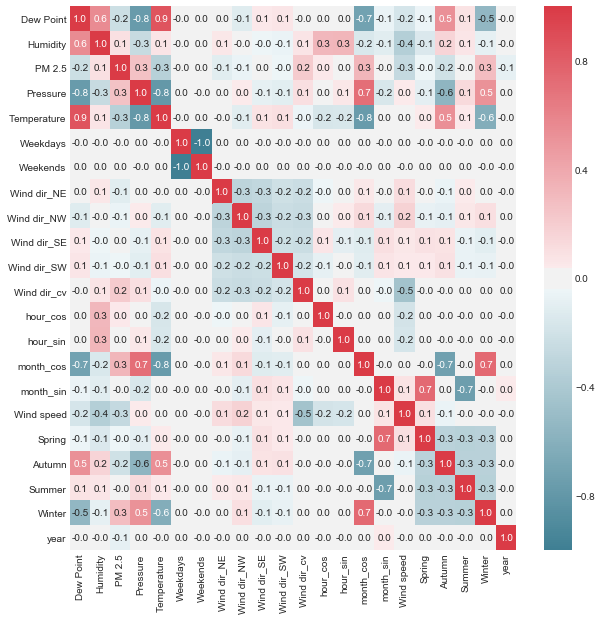

In [24]:
print("All 5 citie: ")
halfHeatMap(dataset, True)

Coastal citie: 


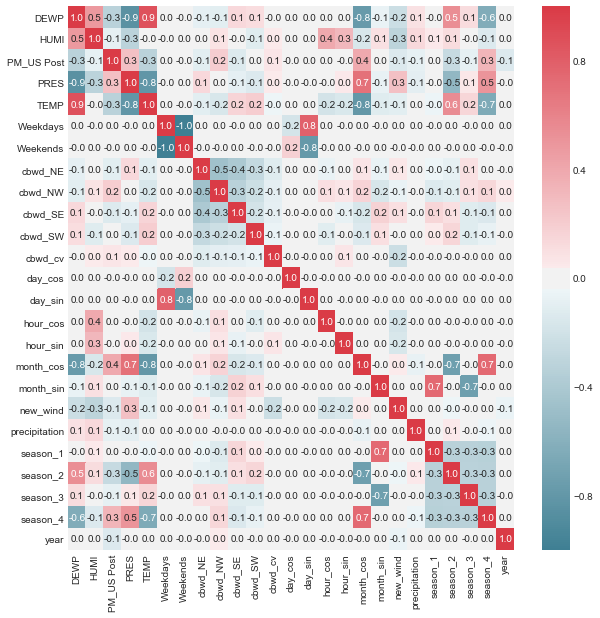

In [10]:
print("Coastal citie: ")
halfHeatMap(coastal_citie, True)

Beijing & Shenyang citie: 


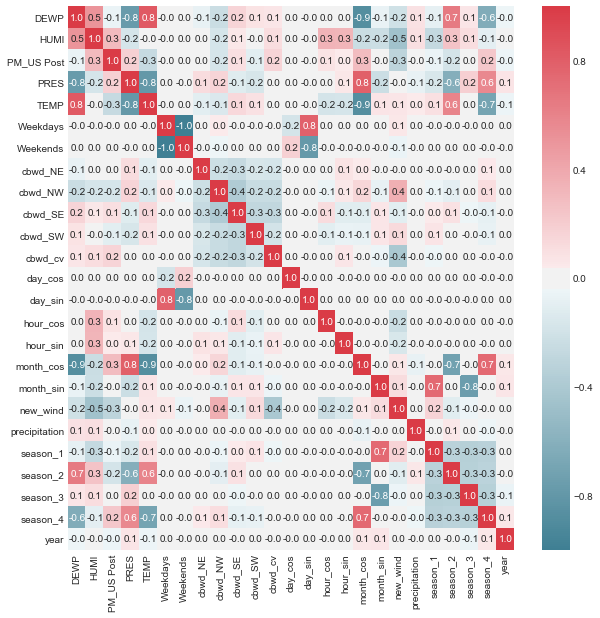

In [11]:
print("Beijing & Shenyang citie: ")
halfHeatMap(Beijing_Shenyang, True)